# Compare genres of input and output books

In [210]:
import gensim
from gensim.models import Doc2Vec, KeyedVectors
import logging
import time
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import requests
import matplotlib.pyplot as plt
import gensim.downloader as api # Downloading the Google pretrained Word2Vec Model

In [211]:
import numpy as np
import requests
import random
from tqdm.notebook import tqdm
tqdm.pandas()

In [212]:
import os
import json
import glob
import re
import sys
import collections
from nltk import flatten
import dask
from dask import delayed,compute
import dask.dataframe as dd
from dask.multiprocessing import get
import logging
from sklearn.metrics.pairwise import cosine_similarity

In [213]:
from sklearn.metrics import multilabel_confusion_matrix
import ast
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from itertools import repeat

## function to generate evaluation metrics

In [222]:
def generate_eval_metrics(books_df, recs_df):
    #Data cleaning
    books_df = books_df.dropna(subset=['genres']) #drop nas (subset-genre)
    #remove quotes from around genre list
    books_df['genres'] = books_df.loc[books_df['genres']!=np.nan, 'genres'].progress_apply(lambda x: ast.literal_eval(x))
    
    #create list of genres
    genres_list = []
    for i in books_df['genres']:
        genres_list.extend(i)
    #create unique list of genres
    unique_genres_list = sorted(list(set(genres_list)))
    unique_genres_df = pd.DataFrame.from_dict({'genres': sorted(unique_genres_list)})
    num_genres = len(unique_genres_list)
    
    orig_book_indices = list(books_df.index)
    num_orig_books = len(orig_book_indices)
    
    #more data cleaning: create list of indices in recs not present in orig. books
    missing_orig_books_indices_list = []
    for idx in list(set(recs_df['orig_book_idx'])):
        if idx not in orig_book_indices:
            missing_orig_books_indices_list.append(idx)
    recommended_books_df_rows_to_remove = []
    for row_num in range(recs_df.shape[0]):
        if recs_df['orig_book_idx'][row_num] in (missing_orig_books_indices_list):
            recommended_books_df_rows_to_remove.append(row_num)
    #remove books from recommended books that have orig books with those indices
    recs_df = recs_df.drop(recommended_books_df_rows_to_remove, axis=0)
    
    #Original books genres -> matrix
    #binarizer to transform between labels and a multilabel format
    mlb = MultiLabelBinarizer()
    #fit the binarizer to the list of genres
    mlb.fit([sorted(unique_genres_list)])
    
    #orig books -> matrix form
    num_preds_per_book = 5
    orig_book_genres_matrix = []
    for orig_book_index in orig_book_indices:
        orig_book = books_df.iloc[books_df.index==orig_book_index]
        orig_book_genres = orig_book['genres']
        orig_book_genres_matrix.extend(np.repeat(mlb.transform(orig_book_genres), repeats = num_preds_per_book, axis=0))
        
    y_expected = np.array(orig_book_genres_matrix)    
    
    #Cleaning: if genre = NaN, replace with '[]'
    recs_df.loc[recs_df['genres'].isna(), 'genres']='[]'
    #Cleaning: recommended_books = recommended_books.dropna(subset=['genres'])
    recs_df['genres'] = recs_df['genres'].progress_apply(lambda x: ast.literal_eval(x))
    recommended_books_genres = list(recs_df['genres'])
    
     #predictions -> matrix form
    y_pred = mlb.transform(recommended_books_genres)
    
    #Create most popular genres list
    counter=collections.Counter(genres_list)
    most_popular_genres_list = [value for value, count in counter.most_common(15)]
    
    #Create evaluation metrics table
    eval_metrics_pop = pd.DataFrame()
    eval_metrics_pop.loc[:,'genre'] = most_popular_genres_list
    eval_metrics_pop.loc[:,'precision']=''
    eval_metrics_pop.loc[:,'recall']=''
    eval_metrics_pop.loc[:,'f1score']=''
    precision_list = []
    for j in tqdm(range(len(most_popular_genres_list))):
        genre = most_popular_genres_list[j]
        i = unique_genres_list.index(genre)
        eval_metrics_pop.iloc[j,1] = precision_score(y_expected[:,i], y_pred[:,i])
        eval_metrics_pop.iloc[j,2] = recall_score(y_expected[:,i], y_pred[:,i])
        eval_metrics_pop.iloc[j,3]= f1_score(y_expected[:,i], y_pred[:,i])
    
    return eval_metrics_pop

In [225]:
#Average word vectors: first 10000 of medium dataset
#read dataset
books_df = pd.read_csv('medium_books_missing_obs23675.csv')[:10000]
#Read in recommendations as df
recs_df = pd.read_csv('avg_word_vec_recs_medium_dataset_first10000.csv')
eval_metrics_avg_word_vecs_first10000_medium = generate_eval_metrics(books_df, recs_df)
eval_metrics_avg_word_vecs_first10000_medium.to_csv('eval_metrics_avg_word_vecs_first10000_medium.csv')

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

In [226]:
#paragraph vectors: first 10000:
books_df = pd.read_csv('medium_books_missing_obs23675.csv')[:10000]
recs_df = pd.read_csv('paragraph_vecs_recs_medium_dataset_first10000.csv')
eval_metrics_paragraph_first10000_medium = generate_eval_metrics(books_df, recs_df)
eval_metrics_paragraph_first10000_medium.to_csv('eval_metrics_paragraph_first10000_medium.csv')

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

## plot all methods

In [264]:
#random recommender
random_eval_metrics_df = pd.read_csv('eval_metrics_pop_random_mediumdataset_first10000.csv').iloc[:,1:]
random_eval_metrics_df = random_eval_metrics_df.rename(columns = {'precision': 'precision_random',
                                                                  'recall': 'recall_random',
                                                                 'f1score': 'f1score_random'})

In [265]:
eval_metrics_avg_word_vecs_first10000_medium =eval_metrics_avg_word_vecs_first10000_medium.rename(columns = {'precision': 'precision_avg_word2vec',
                                                                  'recall': 'recall_avg_word2vec',
                                                                 'f1score': 'f1score_avg_word2vec'})
eval_metrics_comparison = pd.merge(random_eval_metrics_df, eval_metrics_avg_word_vecs_first10000_medium, on = 'genre', how = 'inner')

In [266]:
eval_metrics_comparison

,genre,precision_random,recall_random,f1score_random,precision_avg_word2vec,recall_avg_word2vec,f1score_avg_word2vec
0,Fantasy,0.354891,0.355369,0.355130,0.362414,0.334006,0.347631
1,Fiction,0.587482,0.591248,0.589359,0.597397,0.566757,0.581674
2,Romance,0.274192,0.271772,0.272977,0.275292,0.244128,0.258775
3,Young Adult,0.289678,0.287426,0.288547,0.284622,0.279019,0.281793
4,Historical,0.148706,0.150646,0.149669,0.149826,0.122222,0.134624
5,Paranormal,0.136322,0.135425,0.135872,0.130866,0.129304,0.13008
6,Classics,0.161086,0.162972,0.162023,0.205449,0.188035,0.196357
7,Science Fiction,0.118172,0.118010,0.118091,0.125261,0.113379,0.119024
8,Mystery,0.114850,0.113255,0.114047,0.111074,0.118665,0.114744
9,Historical Fiction,0.139516,0.141706,0.140603,0.144848,0.114949,0.128178


### Add Paragraph vecs  to the comparison

In [267]:
#paragraph_eval_metrics_first10000_medium = pd.read_csv('eval_metrics_pop_paragraph_medium_dataset.csv')
#eval_metrics_paragraph_first10000_medium = eval_metrics_paragraph_first10000_medium.set_index('genre')
paragraph_eval_metrics = eval_metrics_paragraph_first10000_medium
paragraph_eval_metrics = paragraph_eval_metrics.rename(columns = {'precision': 'precision_paragraph',
                                                                  'recall': 'recall_paragraph',
                                                                 'f1score': 'f1score_paragraph'})
eval_metrics_comparison = pd.merge(eval_metrics_comparison , paragraph_eval_metrics , on = 'genre', how = 'inner')
eval_metrics_comparison

,genre,precision_random,recall_random,f1score_random,precision_avg_word2vec,recall_avg_word2vec,f1score_avg_word2vec,precision_paragraph,recall_paragraph,f1score_paragraph
0,Fantasy,0.354891,0.355369,0.355130,0.362414,0.334006,0.347631,0.361529,0.329745,0.344906
1,Fiction,0.587482,0.591248,0.589359,0.597397,0.566757,0.581674,0.592807,0.565299,0.578726
2,Romance,0.274192,0.271772,0.272977,0.275292,0.244128,0.258775,0.274191,0.255872,0.264715
3,Young Adult,0.289678,0.287426,0.288547,0.284622,0.279019,0.281793,0.281982,0.250298,0.265197
4,Historical,0.148706,0.150646,0.149669,0.149826,0.122222,0.134624,0.156318,0.129457,0.141625
5,Paranormal,0.136322,0.135425,0.135872,0.130866,0.129304,0.13008,0.136255,0.148432,0.142083
6,Classics,0.161086,0.162972,0.162023,0.205449,0.188035,0.196357,0.171349,0.139043,0.153515
7,Science Fiction,0.118172,0.118010,0.118091,0.125261,0.113379,0.119024,0.116366,0.112693,0.1145
8,Mystery,0.114850,0.113255,0.114047,0.111074,0.118665,0.114744,0.113123,0.118305,0.115656
9,Historical Fiction,0.139516,0.141706,0.140603,0.144848,0.114949,0.128178,0.146763,0.119454,0.131708


In [268]:
paragraph_eval_metrics

,precision_paragraph,recall_paragraph,f1score_paragraph
genre,,,
Fantasy,0.361529,0.329745,0.344906
Fiction,0.592807,0.565299,0.578726
Romance,0.274191,0.255872,0.264715
Young Adult,0.281982,0.250298,0.265197
Historical,0.156318,0.129457,0.141625
Paranormal,0.136255,0.148432,0.142083
Classics,0.171349,0.139043,0.153515
Science Fiction,0.116366,0.112693,0.1145
Mystery,0.113123,0.118305,0.115656


### Add TF-IDF  to the comparison

In [269]:
tfidf_eval_metrics = pd.read_csv('eval_metrics_pop_tfidf_mediumdataset_first10000.csv')
tfidf_eval_metrics = tfidf_eval_metrics.iloc[:,1:]
tfidf_eval_metrics = tfidf_eval_metrics.rename(columns = {'precision': 'precision_tfidf',
                                                                  'recall': 'recall_tfidf',
                                                                 'f1score': 'f1score_tfidf'})
eval_metrics_comparison = pd.merge(eval_metrics_comparison , tfidf_eval_metrics , on = 'genre', how = 'inner')
eval_metrics_comparison

,genre,precision_random,recall_random,f1score_random,precision_avg_word2vec,recall_avg_word2vec,f1score_avg_word2vec,precision_paragraph,recall_paragraph,f1score_paragraph,precision_tfidf,recall_tfidf,f1score_tfidf
0,Fantasy,0.354891,0.355369,0.355130,0.362414,0.334006,0.347631,0.361529,0.329745,0.344906,0.620619,0.611606,0.616080
1,Fiction,0.587482,0.591248,0.589359,0.597397,0.566757,0.581674,0.592807,0.565299,0.578726,0.737633,0.642402,0.686732
2,Romance,0.274192,0.271772,0.272977,0.275292,0.244128,0.258775,0.274191,0.255872,0.264715,0.581878,0.602845,0.592176
3,Young Adult,0.289678,0.287426,0.288547,0.284622,0.279019,0.281793,0.281982,0.250298,0.265197,0.574910,0.517198,0.544529
4,Historical,0.148706,0.150646,0.149669,0.149826,0.122222,0.134624,0.156318,0.129457,0.141625,0.341392,0.394057,0.365839
5,Paranormal,0.136322,0.135425,0.135872,0.130866,0.129304,0.13008,0.136255,0.148432,0.142083,0.490656,0.490130,0.490393
6,Classics,0.161086,0.162972,0.162023,0.205449,0.188035,0.196357,0.171349,0.139043,0.153515,0.471826,0.395466,0.430284
7,Science Fiction,0.118172,0.118010,0.118091,0.125261,0.113379,0.119024,0.116366,0.112693,0.1145,0.403368,0.345111,0.371973
8,Mystery,0.114850,0.113255,0.114047,0.111074,0.118665,0.114744,0.113123,0.118305,0.115656,0.395409,0.301353,0.342033
9,Historical Fiction,0.139516,0.141706,0.140603,0.144848,0.114949,0.128178,0.146763,0.119454,0.131708,0.346814,0.325461,0.335798


## Add BERT to the comparison

In [270]:
bert_eval_metrics = pd.read_csv('eval_metrics_pop_bert_mediumdataset_first10000.csv')
bert_eval_metrics = bert_eval_metrics.iloc[:,1:]
bert_eval_metrics = bert_eval_metrics.rename(columns = {'precision': 'precision_bert',
                                                                  'recall': 'recall_bert',
                                                                 'f1score': 'f1score_bert'})
eval_metrics_comparison = pd.merge(eval_metrics_comparison , bert_eval_metrics , on = 'genre', how = 'inner')
eval_metrics_comparison

,genre,precision_random,recall_random,f1score_random,precision_avg_word2vec,recall_avg_word2vec,f1score_avg_word2vec,precision_paragraph,recall_paragraph,f1score_paragraph,precision_tfidf,recall_tfidf,f1score_tfidf,precision_bert,recall_bert,f1score_bert
0,Fantasy,0.354891,0.355369,0.355130,0.362414,0.334006,0.347631,0.361529,0.329745,0.344906,0.620619,0.611606,0.616080,0.467022,0.575273,0.515526
1,Fiction,0.587482,0.591248,0.589359,0.597397,0.566757,0.581674,0.592807,0.565299,0.578726,0.737633,0.642402,0.686732,0.662217,0.674729,0.668414
2,Romance,0.274192,0.271772,0.272977,0.275292,0.244128,0.258775,0.274191,0.255872,0.264715,0.581878,0.602845,0.592176,0.440689,0.507805,0.471872
3,Young Adult,0.289678,0.287426,0.288547,0.284622,0.279019,0.281793,0.281982,0.250298,0.265197,0.574910,0.517198,0.544529,0.411895,0.454571,0.432182
4,Historical,0.148706,0.150646,0.149669,0.149826,0.122222,0.134624,0.156318,0.129457,0.141625,0.341392,0.394057,0.365839,0.269905,0.294315,0.281582
5,Paranormal,0.136322,0.135425,0.135872,0.130866,0.129304,0.13008,0.136255,0.148432,0.142083,0.490656,0.490130,0.490393,0.234959,0.321500,0.271500
6,Classics,0.161086,0.162972,0.162023,0.205449,0.188035,0.196357,0.171349,0.139043,0.153515,0.471826,0.395466,0.430284,0.428378,0.359320,0.390822
7,Science Fiction,0.118172,0.118010,0.118091,0.125261,0.113379,0.119024,0.116366,0.112693,0.1145,0.403368,0.345111,0.371973,0.193932,0.187479,0.190651
8,Mystery,0.114850,0.113255,0.114047,0.111074,0.118665,0.114744,0.113123,0.118305,0.115656,0.395409,0.301353,0.342033,0.195400,0.200721,0.198025
9,Historical Fiction,0.139516,0.141706,0.140603,0.144848,0.114949,0.128178,0.146763,0.119454,0.131708,0.346814,0.325461,0.335798,0.260848,0.287235,0.273407


## Side by side bar plot: Precision:

In [276]:
precision_df = eval_metrics_comparison.iloc[:,[0,1,10,4,7,13]]
precision_df = precision_df.set_index('genre')

In [277]:
precision_df

,precision_random,precision_tfidf,precision_avg_word2vec,precision_paragraph,precision_bert
genre,,,,,
Fantasy,0.354891,0.620619,0.362414,0.361529,0.467022
Fiction,0.587482,0.737633,0.597397,0.592807,0.662217
Romance,0.274192,0.581878,0.275292,0.274191,0.440689
Young Adult,0.289678,0.574910,0.284622,0.281982,0.411895
Historical,0.148706,0.341392,0.149826,0.156318,0.269905
Paranormal,0.136322,0.490656,0.130866,0.136255,0.234959
Classics,0.161086,0.471826,0.205449,0.171349,0.428378
Science Fiction,0.118172,0.403368,0.125261,0.116366,0.193932
Mystery,0.114850,0.395409,0.111074,0.113123,0.195400


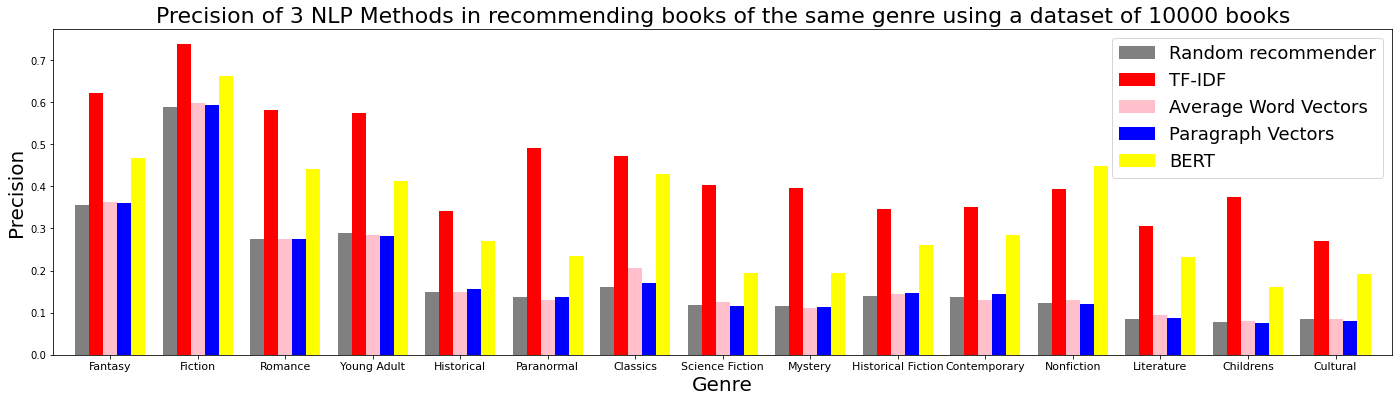

In [279]:
precision_df.plot(kind='bar', rot=0, color = ['grey', 'red','pink', 'blue','yellow'],width=0.8, figsize=(24, 6))
plt.title("Precision of 4 NLP Methods in recommending books of the same genre using a dataset of 10000 books", size=22)
plt.xlabel("Genre", size=20)
plt.ylabel("Precision", size=20)
plt.xticks(size=11)
plt.legend(prop={'size': 18}, labels =['Random recommender', 'TF-IDF','Average Word Vectors','Paragraph Vectors','BERT'])
plt.savefig('all_methods_medium_dataset_first10000_bar_chart_precision_top15.jpeg')
plt.show()

## Side by side bar plot: Recall:

In [282]:
recall_df = eval_metrics_comparison.iloc[0:15,[0,2,11,5,8,14]]
recall_df = recall_df.set_index('genre')
recall_df

,recall_random,recall_tfidf,recall_avg_word2vec,recall_paragraph,recall_bert
genre,,,,,
Fantasy,0.355369,0.611606,0.334006,0.329745,0.575273
Fiction,0.591248,0.642402,0.566757,0.565299,0.674729
Romance,0.271772,0.602845,0.244128,0.255872,0.507805
Young Adult,0.287426,0.517198,0.279019,0.250298,0.454571
Historical,0.150646,0.394057,0.122222,0.129457,0.294315
Paranormal,0.135425,0.490130,0.129304,0.148432,0.321500
Classics,0.162972,0.395466,0.188035,0.139043,0.359320
Science Fiction,0.118010,0.345111,0.113379,0.112693,0.187479
Mystery,0.113255,0.301353,0.118665,0.118305,0.200721


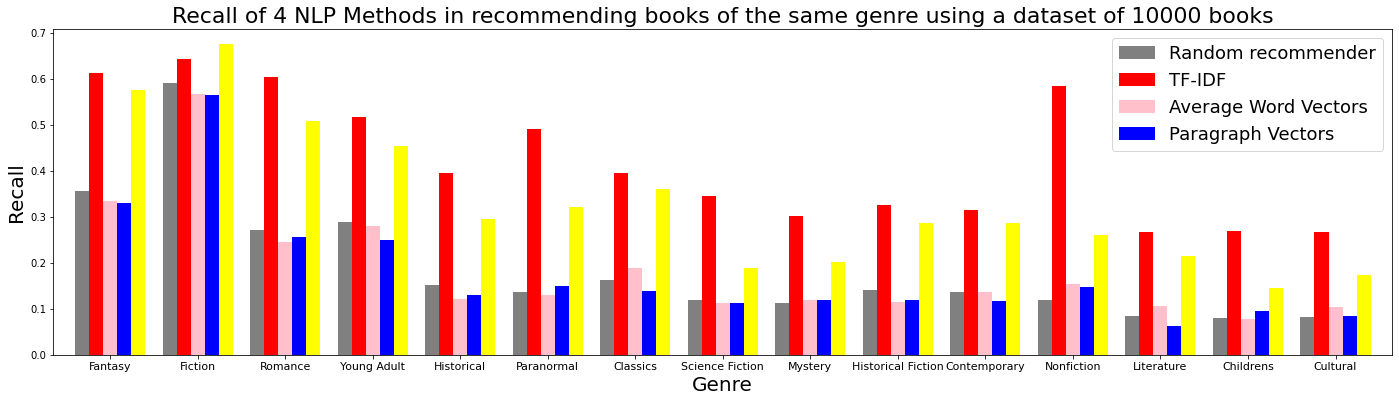

In [289]:
recall_df.plot(kind='bar', rot=0, color = ['grey', 'red','pink', 'blue','yellow'],width=0.8, figsize=(24, 6))
plt.title("Recall of 4 NLP Methods in recommending books of the same genre using a dataset of 10000 books", size=22)
plt.xlabel("Genre", size=20)
plt.ylabel("Recall", size=20)
plt.xticks(size=11)
plt.legend(prop={'size': 18}, labels =['Random recommender','TF-IDF', 'Average Word Vectors','Paragraph Vectors'])
plt.savefig('all_methods_medium_dataset_first10000_bar_chart_recall_top15.jpeg')
plt.show()